In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iminuit
from iminuit import Minuit, cost
from numba_stats import norm, truncexpon, crystalball, expon
from scipy.optimize import curve_fit
import mplhep as hep
from numba import jit
hep.style.use("LHCb2")

np.random.seed(42)

In [2]:
BINS = 50

In [3]:
from numba import jit
@jit
def signal(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

from scipy.stats import halfnorm
def combinatorial(x, mu, sigma, n):
    result = n * halfnorm.cdf(x, mu, sigma)
    # result = np.zeros(len(x))
    # result = np.where(x > 5100, n * norm.cdf(x, mu, sigma), 0)
    return result
@jit
def background(x, tau, xoffset, norm):
    result = norm * expon.cdf(x, xoffset, tau)
    return result
    #return norm * truncexpon.cdf(x, x[0], x[-1], xoffset, tau)

@jit
def cdf(x, norm_mu, norm_sigma, norm_n,
        comb_mu, comb_sigma, comb_n,
        tau, xoffset, norm,
        total_norm):
    
    signal_result = signal(x, norm_mu, norm_sigma, norm_n)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

@jit
def crystal_signal(x, beta, m, loc, scale, n):
    return n * crystalball.cdf(x, beta, m, loc, scale)
@jit
def cdf_crystal(x,
                crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm,
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, norm,
                total_norm):
    
    signal_result = crystal_signal(x, crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, comb_mu, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)
    plt.clf()

    return popt, pcov

In [4]:
data_minus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/region_local_Bminus (3).csv")
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/region_local_Bplus.csv")


data_plus = data_plus[(data_plus > 5100) & (data_plus < 5600)]
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)

data_minus = data_minus[(data_minus > 5100) & (data_minus < 5600)]
n_minus, xe_minus = np.histogram(data_minus, bins=BINS)
c_crystal_minus = cost.ExtendedBinnedNLL(n_minus, xe_minus, cdf_crystal)


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


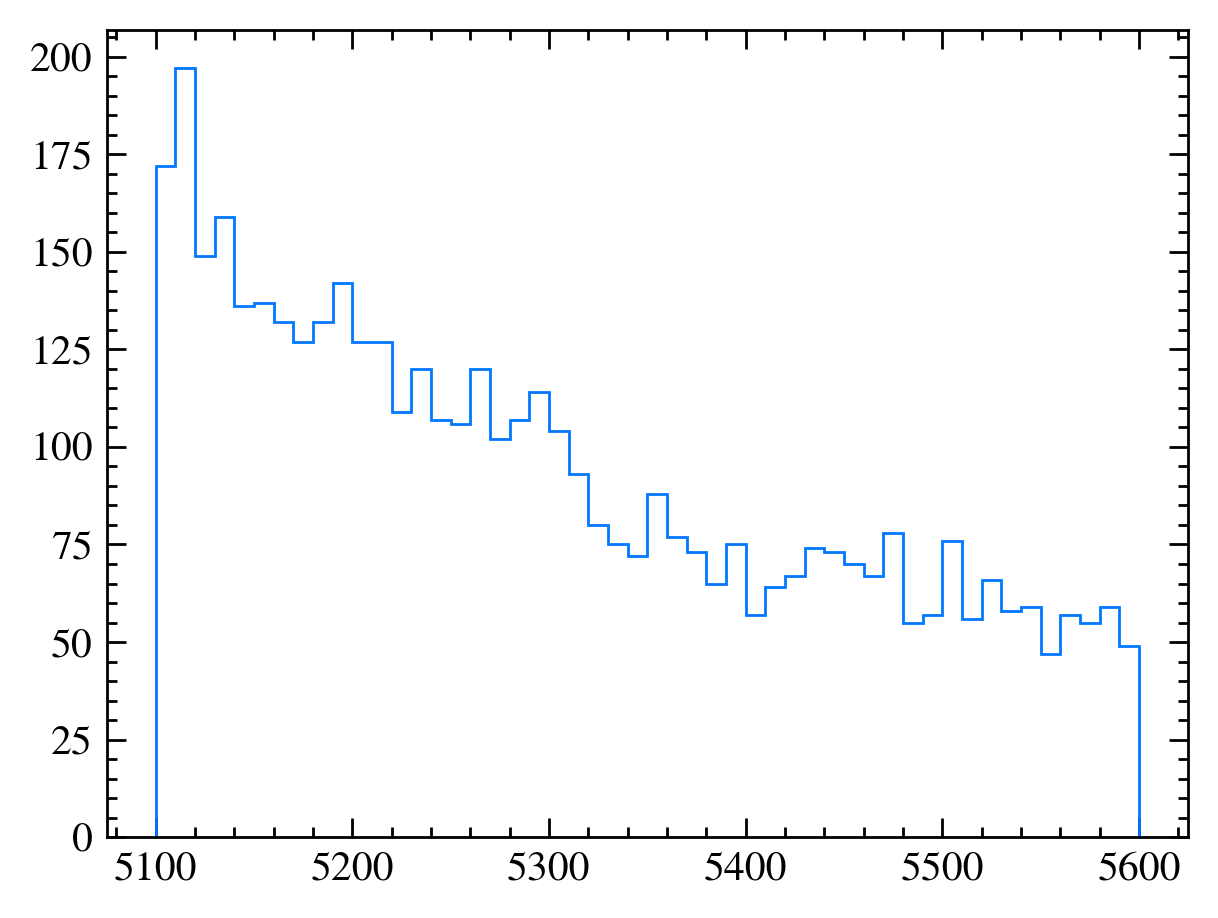

In [5]:
#plot the data
plt.hist(data_plus, bins=BINS, histtype='step', label='raw data');

In [6]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5280, 5310)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True


In [7]:
n_plus_c.migrad(iterate=20, ncall=300000).migrad()
n_plus_c.interactive()

/tmp/ipykernel_56320/788870761.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cdf_crystal" failed type inference due to: Untyped global name 'combinatorial': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_56320/788870761.py", line 40:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cdf_crystal" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_56320/788870761.py", line 32:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.94 (χ²/ndof = 1.1)      │             Nfcn = 1615              │
│ EDM = 2.62e-05 (Goal: 0.0002)    │            time = 6.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │   1.200   │   0.012   │            │            │         │         │  yes  │
│ 1 │ crystal_m     │   1.003   │   0.010   │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │  5.280e3  │  0.026e3  │            │            │  5280   │  5310   │       │
│ 3 │ crystal_scale │    22     │     7     │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │   0.2e3   │   0.5e3   │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │    50     │     7     │            │            │    1    │   50    │       │
│ 7 │ comb_n        │    8.4    │    2.7    │            │            │    1    │  10000  │       │
│ 8 │ tau           │    500    │    40     │            │            │         │         │       │
│ 9 │ xoffset       │  4.28e3   │  0.08e3   │            │            │         │         │       │
│ 10│ norm          │  1.19e3   │  0.19e3   │            │            │         │         │       │
│ 11│ total_norm    │    29     │     4     │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0             0             0             0             0             0        0.0000             0             0           0e3             0             0 │
│     crystal_m │             0      9.51e-05            -0       2.76e-3      -4.76346             0             0       1.26e-3      15.29e-3       0.99e-3       1.96e-3      -1.43e-3 │
│   crystal_loc │             0            -0      0.000788       -2.1e-3       -8.0e-3             0            -0       -0.2e-3       -4.7e-3        2.3e-3        5.7e-3        0.1e-3 │
│ crystal_scale │             0       2.76e-3       -2.1e-3          49.7           150             0        0.0000             3            60           -30           -80            -1 │
│  crystal_norm │             0      -4.76346       -8.0e-3           150      2.45e+05             0        0.0007            71         0.9e3           0e3             0 

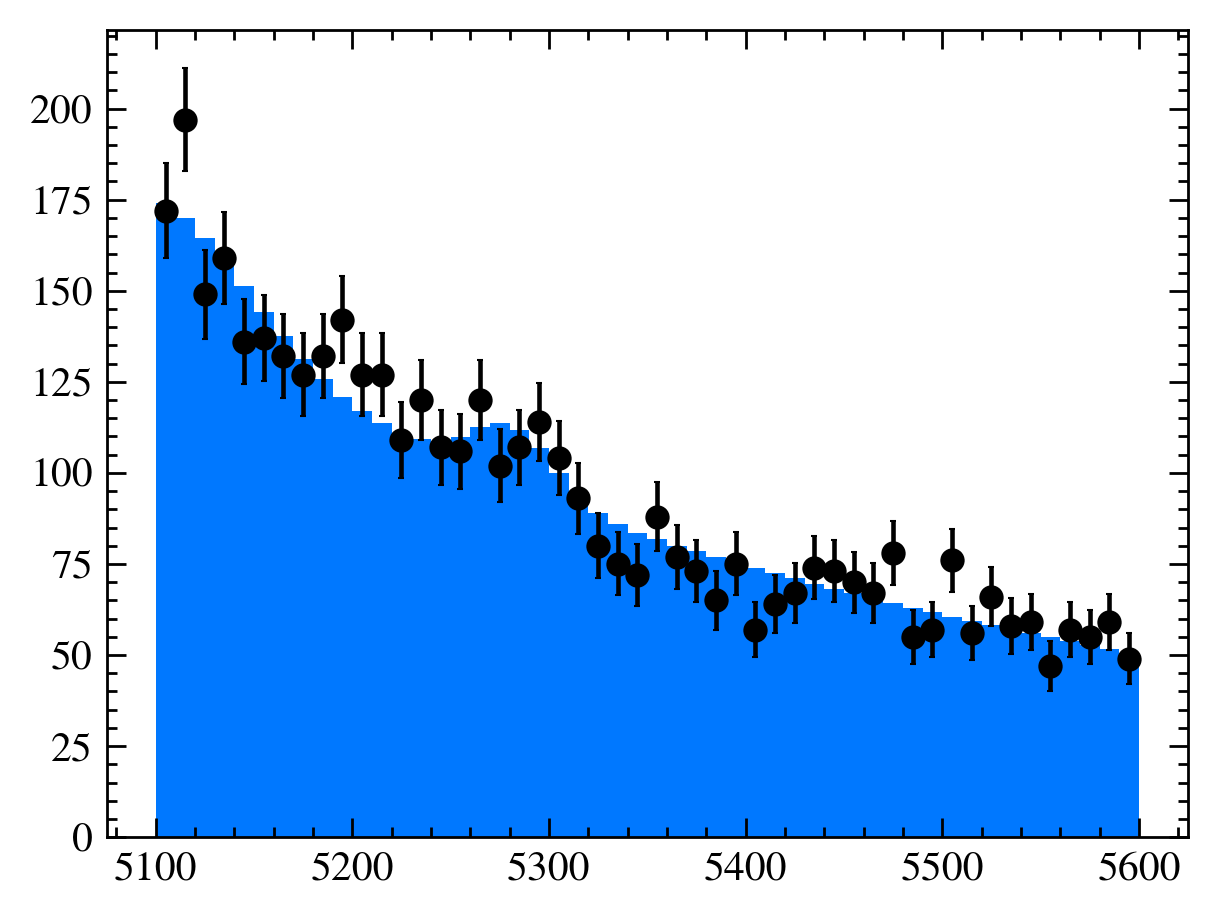

In [8]:
n_plus_c.hesse()

In [9]:
def fit_curve_post_minut_bounded(data, p0_vals, upper, lower):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    unc_vals = np.sqrt(bin_heihgts)

    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals, bounds=(lower, upper),
                           sigma=unc_vals, absolute_sigma=True)
    plt.clf()
    return popt, pcov

In [10]:
array_of_p0 = np.array([n_plus_c.values["crystal_beta"],
                        n_plus_c.values["crystal_m"],
                        n_plus_c.values["crystal_loc"],
                        n_plus_c.values["crystal_scale"],
                        n_plus_c.values["crystal_norm"],
                        n_plus_c.values["comb_mu"],
                        n_plus_c.values["comb_sigma"],
                        n_plus_c.values["comb_n"],
                        n_plus_c.values["tau"],
                        n_plus_c.values["xoffset"],
                        n_plus_c.values["norm"],
                        n_plus_c.values["total_norm"]])

array_of_p0[0] = 1.1
array_of_p0[1] = 0.8119
array_of_p0[2] = 5284.3
array_of_p0[3] = 20.6
array_of_p0[4] = 1.13
array_of_p0[5] = 5100
array_of_p0[6] = 30
array_of_p0[7] = 965
# tau, xoffset, norm,
array_of_p0[8] = 80
array_of_p0[9] = 7310
array_of_p0[10] = 1.1

In [11]:
epsilon = 10

upper_crystal = array_of_p0 + epsilon
lower_crystal = array_of_p0 - epsilon

#free the normalisation parameters in the array_p0_crystal using index
lower_crystal[0] = array_of_p0[0] - 1e-2
upper_crystal[0] = array_of_p0[0] + 1e-2

upper_crystal[1] = array_of_p0[1] + 1e-2
lower_crystal[1] = array_of_p0[1] - 1e-2

upper_crystal[2] = array_of_p0[2] + 1e-1
lower_crystal[2] = array_of_p0[2] - 1e-1

upper_crystal[3] = array_of_p0[3] + 1e-1
lower_crystal[3] = array_of_p0[3] - 1e-1

upper_crystal[4] = 1e8
lower_crystal[4] = 1e-8

upper_crystal[5] = 5101
lower_crystal[5] = 5099

upper_crystal[7] = 1e8
lower_crystal[7] = 1e-8

upper_crystal[8] = 1e8
lower_crystal[8] = 1e-8

upper_crystal[9] = 1e8
lower_crystal[9] = 1e-8

upper_crystal[10] = 1e8
lower_crystal[10] = 1e-8

Number of events:  1217.0976919615237
43.19945827744135 1.0799864569360338 40


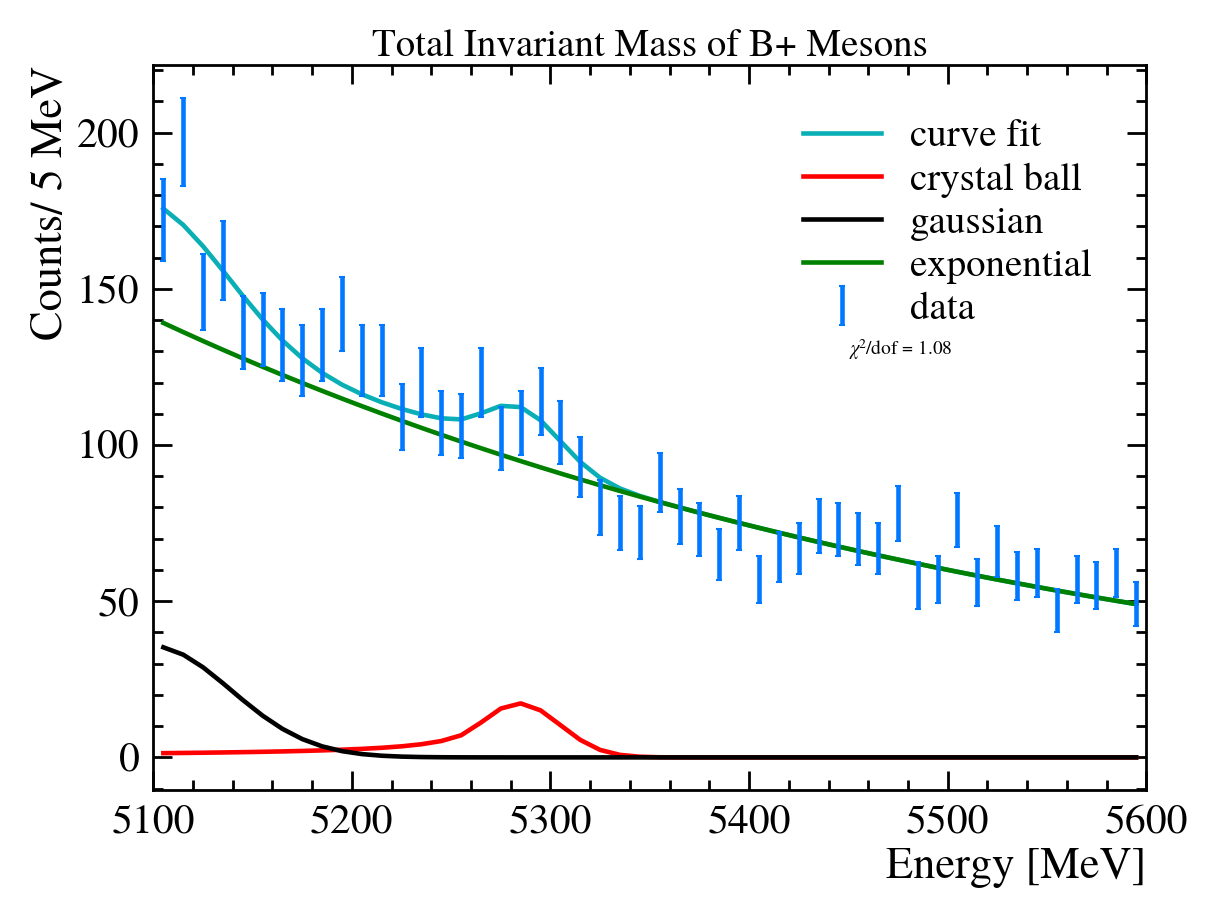

In [12]:

popt, pcov = fit_curve_post_minut_bounded(data_plus, array_of_p0, upper_crystal, lower_crystal)
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
plt.clf()
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part = crystal_part + comb_part + exp_part

positive_bin_centers = bin_centers 
positive_bin_heights = bin_heights
positive_total_part = total_part
positive_crystal_part = crystal_part
positive_comb_part = comb_part
positive_exp_part = exp_part
positive_model = fit_crystal(bin_centers, *popt)


#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              label="data", color="C0",ls="None")
#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

plt.legend()

pure_signal = total_part - comb_part - exp_part

number_of_events = np.trapz(pure_signal, bin_centers)
print("Number of events: ", number_of_events)
print(chi_squared, reduced_chi_squared, dof)

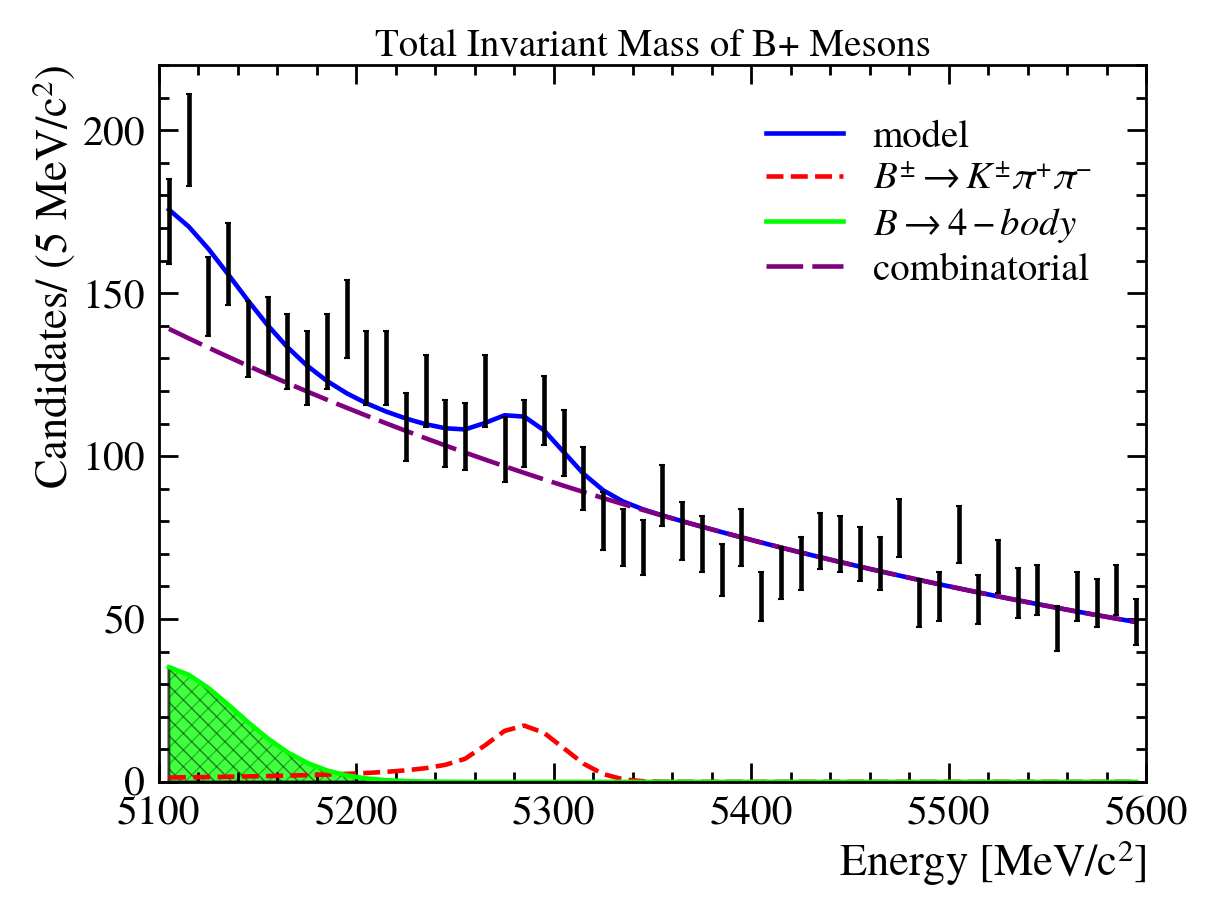

In [13]:
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="model", color="blue")
plt.plot(bin_centers, crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red", 
         ls="dashed")
plt.plot(bin_centers, comb_part, label=r"$B \rightarrow 4-body$", color="lime")
plt.plot(bin_centers, exp_part, label="combinatorial", dashes=[8,2], color="purple")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="//", alpha=0.5, color='lime',
                 edgecolor="black")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                 edgecolor="black")


#limit view to y > 0
plt.ylim(bottom=0, top=220)
#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              color="black",ls="None")
#add labels 
plt.xlabel("Energy [MeV/c$^2$]")
plt.ylabel("Candidates/ (5 MeV/c$^2$)")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
#plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

plt.legend()

# Fitting Bminus

In [14]:
n_minus_c = Minuit(     c_crystal_minus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_minus_c.limits['crystal_m'] = (0, 20)
n_minus_c.limits['crystal_scale'] = (1, 100)
n_minus_c.limits['crystal_norm'] = (1, 1e4)
n_minus_c.limits['crystal_loc'] = (5280, 5310)

n_minus_c.limits['comb_mu'] = (5100, 5101)
n_minus_c.limits['comb_sigma'] = (1, 50)
n_minus_c.limits['comb_n'] = (1, 1e4)

n_minus_c.fixed["crystal_beta"] = True
n_minus_c.fixed["comb_mu"] = True

In [15]:
n_minus_c.migrad(iterate=20, ncall=300000).migrad()
n_minus_c.interactive()

In [16]:
p0_minus = np.array([n_minus_c.values["crystal_beta"],
                        n_minus_c.values["crystal_m"],
                        n_minus_c.values["crystal_loc"],
                        n_minus_c.values["crystal_scale"],
                        n_minus_c.values["crystal_norm"],
                        n_minus_c.values["comb_mu"],
                        n_minus_c.values["comb_sigma"],
                        n_minus_c.values["comb_n"],
                        n_minus_c.values["tau"],
                        n_minus_c.values["xoffset"],
                        n_minus_c.values["norm"],
                        n_minus_c.values["total_norm"]])

p0_minus[6] = 21
p0_minus[8] = 20
p0_minus[9] = 7331
p0_minus[10] = 1.1

In [17]:
epsilon = 10

upper_crystal = p0_minus + epsilon
lower_crystal = p0_minus - epsilon

#free the normalisation parameters in the array_p0_crystal using index
lower_crystal[0] = p0_minus[0] - 1e-1
upper_crystal[0] = p0_minus[0] + 1e-1

upper_crystal[1] = p0_minus[1] + 1e-1
lower_crystal[1] = p0_minus[1] - 1e-1

upper_crystal[2] = p0_minus[2] + 1e-1
lower_crystal[2] = p0_minus[2] - 1e-1

upper_crystal[3] = p0_minus[3] + 1e-1
lower_crystal[3] = p0_minus[3] - 1e-1

upper_crystal[4] = 1e8
lower_crystal[4] = 1e-8



upper_crystal[7] = 1e3
lower_crystal[7] = -1e5

upper_crystal[-2] = 1e8
lower_crystal[-2] = 1e-8

upper_crystal[-3] = 1e8
lower_crystal[-3] = 1e-8

upper_crystal[-4] = 1e8
lower_crystal[-4] = 1e-8

upper_crystal[6] = 50
lower_crystal[6] = 20

upper_crystal[7] = 1e8
lower_crystal[7] = 1e-8

upper_crystal[8] = 1e8
lower_crystal[8] = -1e-8

upper_crystal[9] = 1e8
lower_crystal[9] = 1e-8
upper_crystal[10] = 1e8
lower_crystal[10] = 1e-8

Number of event uncertainty:  602.2205474854177
Number of events:  6750.116002244976


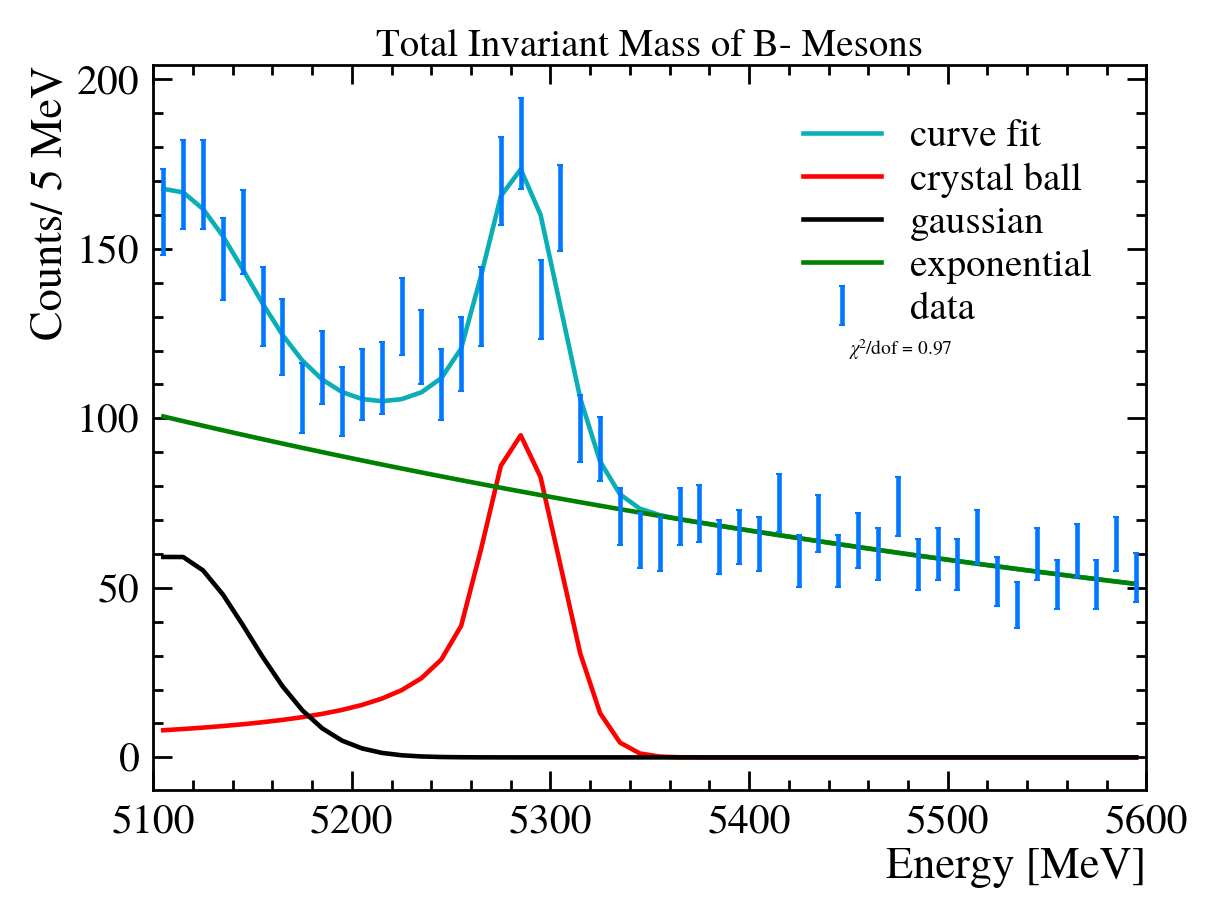

In [18]:

popt, pcov = fit_curve_post_minut_bounded(data_minus, p0_minus, upper_crystal, lower_crystal)
hist_raw = plt.hist(data_minus, bins=BINS, label="raw data", color="C0", alpha=0.5)
plt.clf()
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part = crystal_part + comb_part + exp_part

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              label="data", color="C0",ls="None")
#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B- Mesons")
plt.xlim(5100, 5600)

plt.legend()

pure_signal = total_part - comb_part - exp_part

number_of_events = np.trapz(pure_signal, bin_centers)
#extract undertainties for the number of events
number_of_events_uncertainty = np.sqrt(np.trapz((pure_signal)**2, bin_centers))
print("Number of event uncertainty: ", number_of_events_uncertainty)
print("Number of events: ", number_of_events)

In [19]:
#extract normalisation of the crystal ball
crystal_norm = popt[4]
crystal_norm_uncertainty = np.sqrt(pcov[4,4])
print("Crystal ball normalisation: ", crystal_norm)
print("Crystal ball normalisation uncertainty: ", crystal_norm_uncertainty)

Crystal ball normalisation:  794.255648102397
Crystal ball normalisation uncertainty:  1411392580.653267


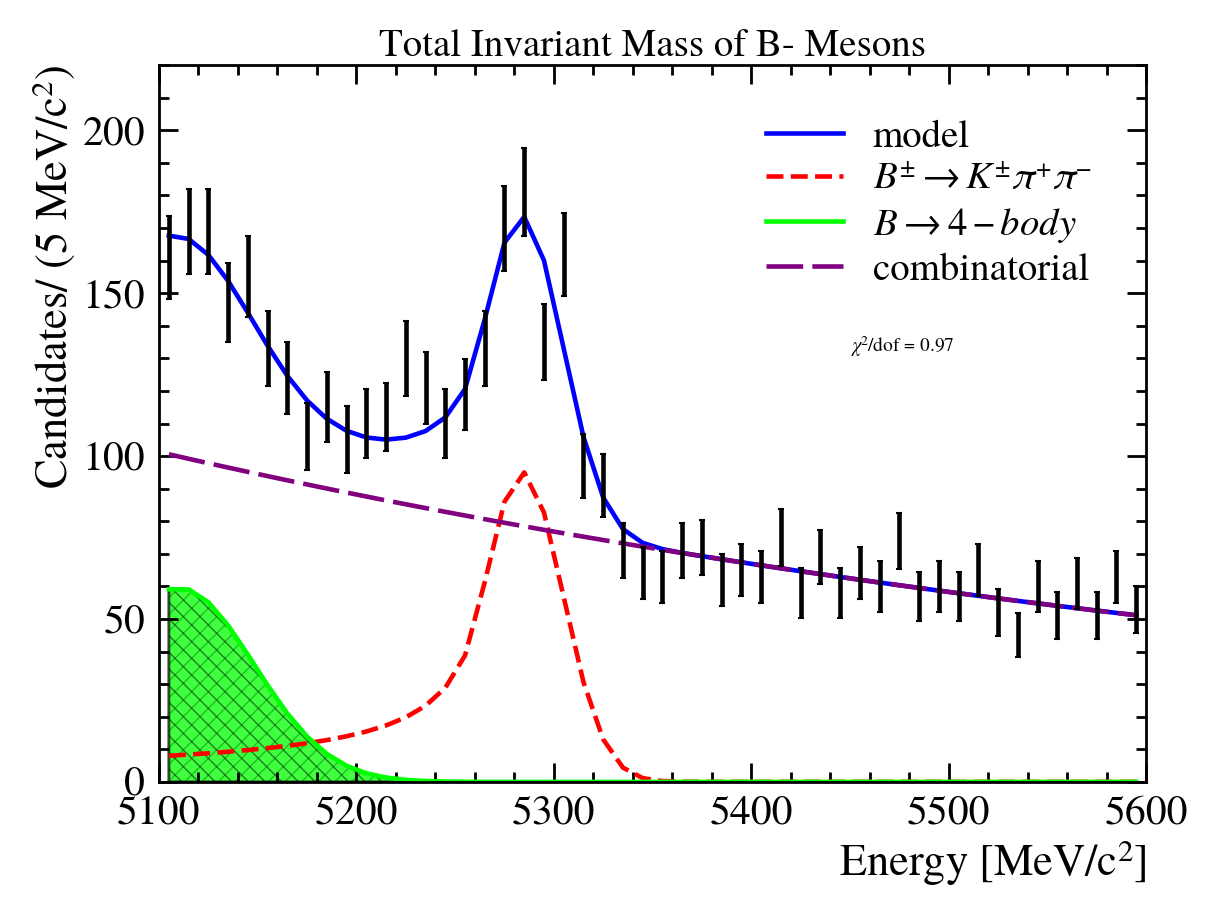

In [20]:
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="model", color="blue")
plt.plot(bin_centers, crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red", 
         ls="dashed")
plt.plot(bin_centers, comb_part, label=r"$B \rightarrow 4-body$", color="lime")
plt.plot(bin_centers, exp_part, label="combinatorial", dashes=[8,2], color="purple")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="//", alpha=0.5, color='lime',
                 edgecolor="black")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                 edgecolor="black")

negative_bin_centers = bin_centers
negative_comb_part = comb_part
negative_crystal_part = crystal_part
negative_exp_part = exp_part
negative_popt = popt
negative_bin_heights = bin_heights
negative_model = fit_crystal(bin_centers, *popt)

#limit view to y > 0
plt.ylim(bottom=0)
#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              color="black",ls="None")
#add labels 
plt.xlabel("Energy [MeV/c$^2$]")
plt.ylabel("Candidates/ (5 MeV/c$^2$)")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B- Mesons")
#set y lim, 
plt.ylim(bottom=0, top=220)
plt.xlim(5100, 5600)

plt.legend()

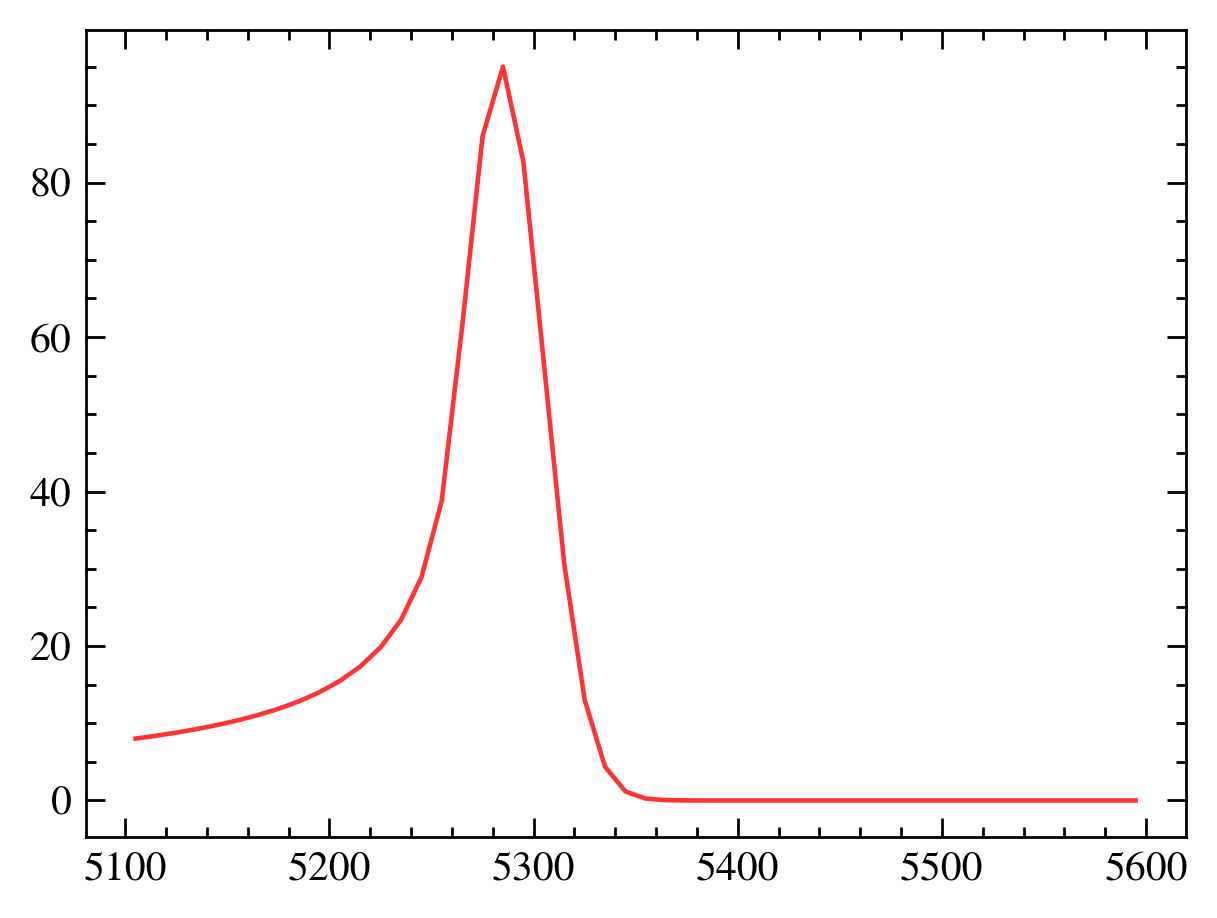

In [21]:
#plot just the pure signal
plt.plot(bin_centers, pure_signal, label="pure signal", color="C3")

#Using this we can set the values of the crystal ball in Bplus fitting

In [22]:
#print popt values alonside name of parameter
for i, param in enumerate(popt):
    print(i, param)


0 1.1
1 0.7452777372647457
2 5284.174875851325
3 20.47735609580448
4 794.255648102397
5 5109.999999999999
6 38.10498988652191
7 3253.2424476078595
8 5865.008740030037
9 724.7043464365727
10 14587.905793083595
11 1.7505003023402503


In [23]:
(6750 - 1217) / (6750+1217)

0.6944897703024978

In [24]:
#if i remove 140 from both 
(6610 - 1277) / (6610+1277)

0.6761759857994167

In [25]:
np.sqrt((1 - 0.6944**2) / (6750 + 1217))

0.008061896860950964

# Final Plotting

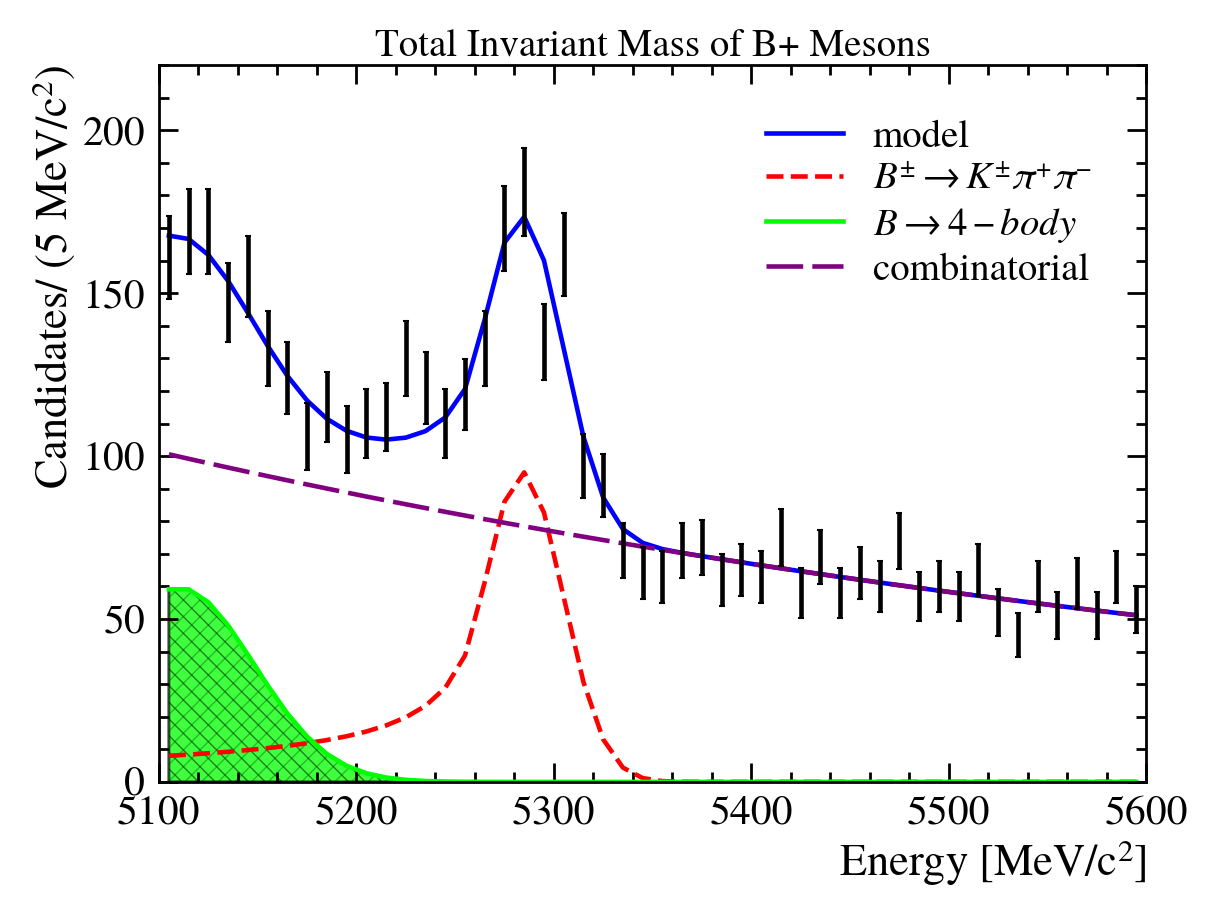

In [26]:
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="model", color="blue")
plt.plot(bin_centers, crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red", 
         ls="dashed")
plt.plot(bin_centers, comb_part, label=r"$B \rightarrow 4-body$", color="lime")
plt.plot(bin_centers, exp_part, label="combinatorial", dashes=[8,2], color="purple")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="//", alpha=0.5, color='lime',
                 edgecolor="black")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                 edgecolor="black")


#limit view to y > 0
plt.ylim(bottom=0, top=220)
#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              color="black",ls="None")
#add labels 
plt.xlabel("Energy [MeV/c$^2$]")
plt.ylabel("Candidates/ (5 MeV/c$^2$)")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
#plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

plt.legend()

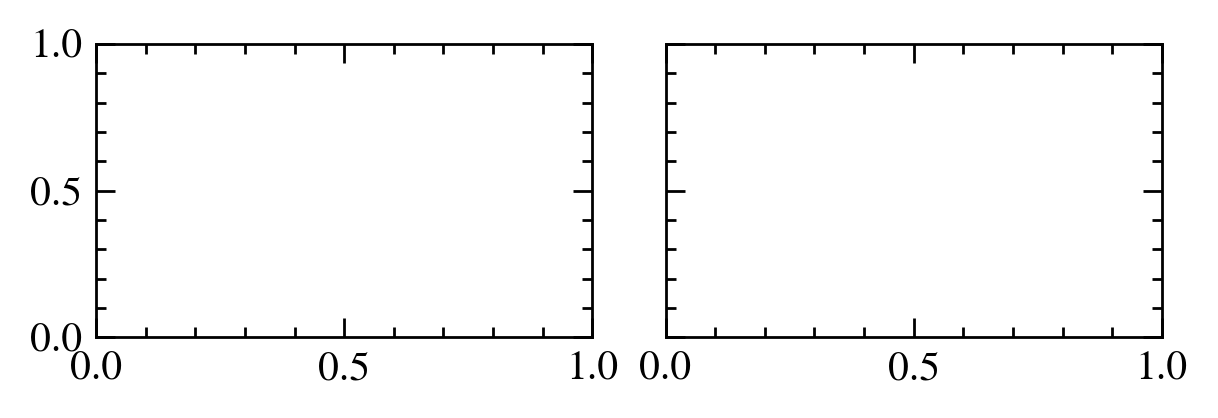

In [27]:
#plot two things side by side using axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

/tmp/ipykernel_56320/3942549752.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0)


<Figure size 2500x100 with 0 Axes>

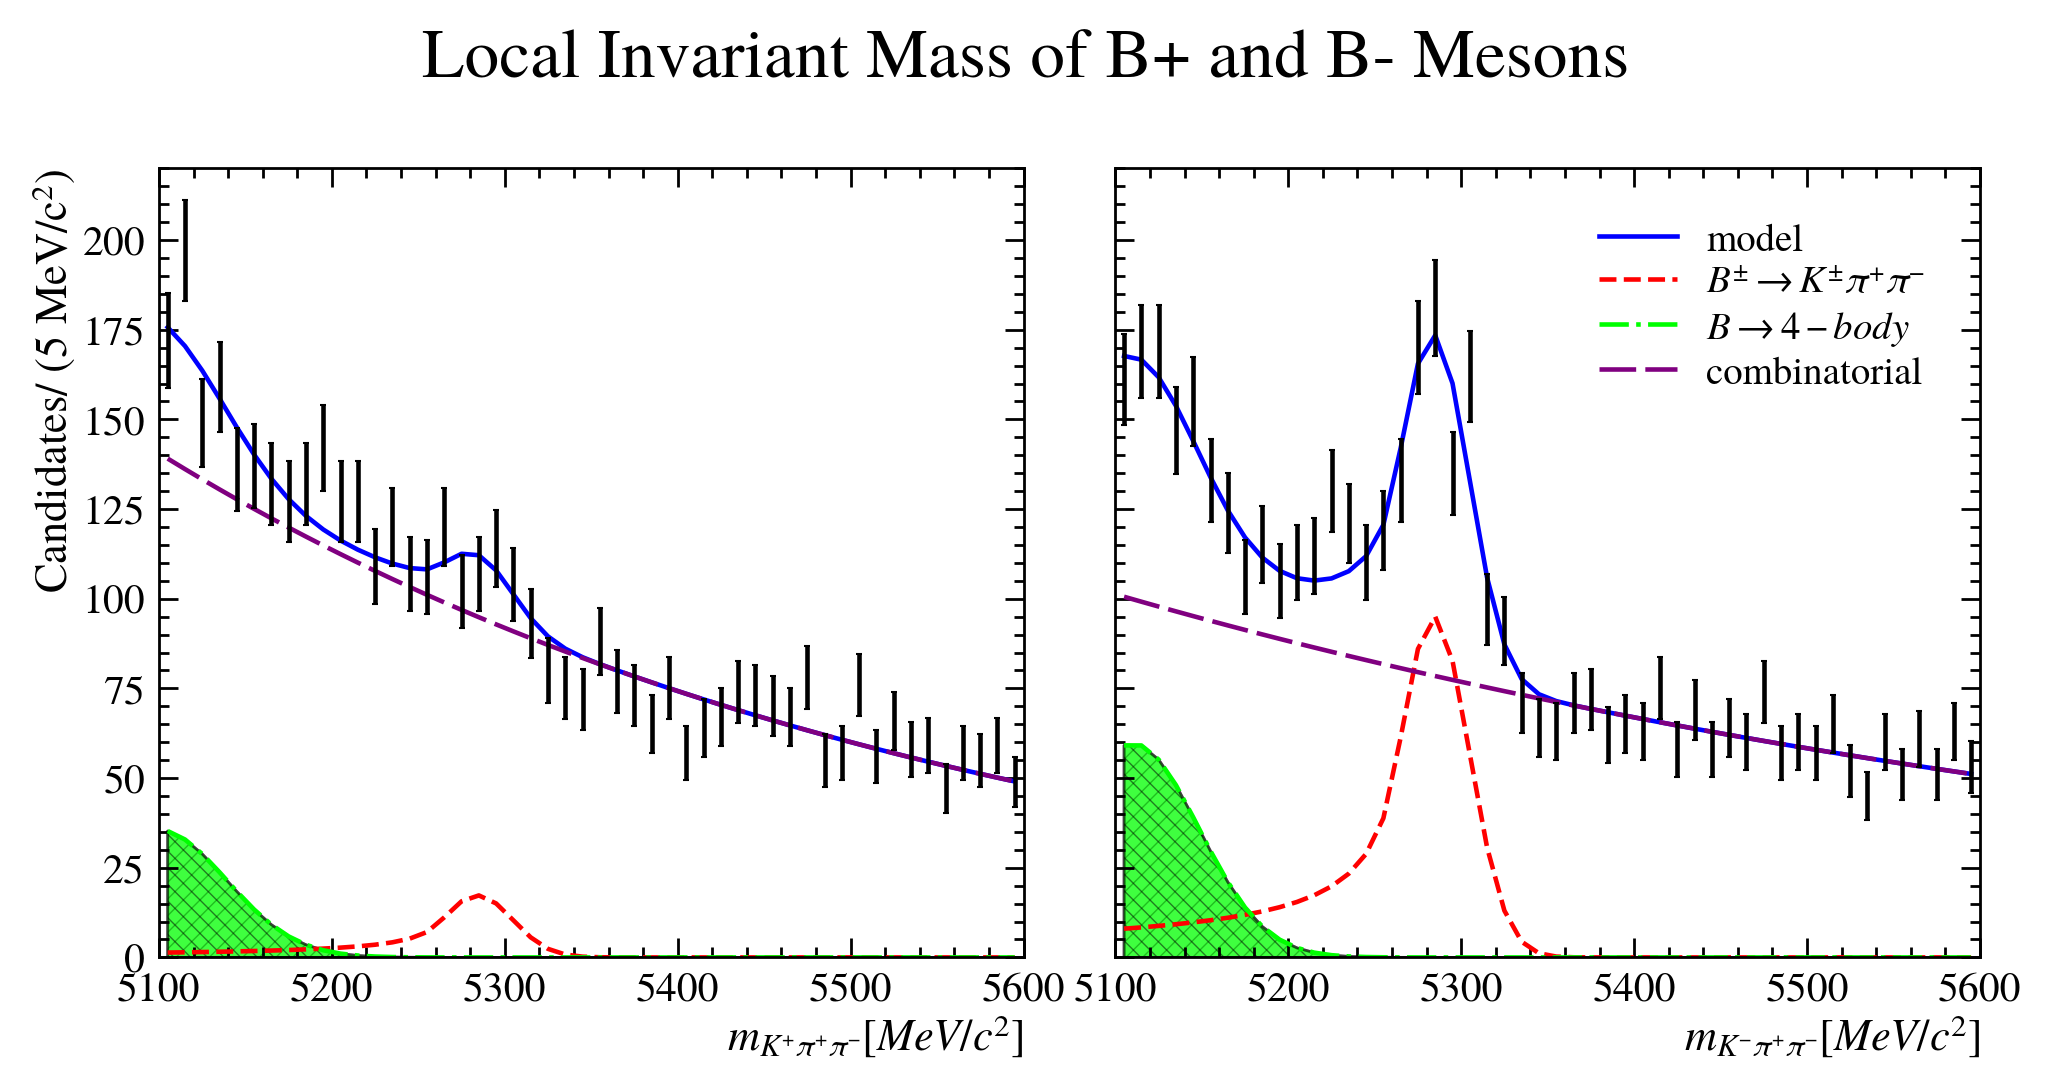

In [28]:
#plot the fits side by side
#change the size of the plot
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(25, 1))
# use two axes to plot the data and the fit parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharey=True, constrained_layout=True,
                               gridspec_kw={'width_ratios': [1, 1],
                                            "wspace":0,
                                            })



#plot the positive results in ax1
ax1.plot(positive_bin_centers, positive_model, label="model", color="blue")
ax1.plot(positive_bin_centers, positive_crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red",
            ls="dashed")    
ax1.plot(positive_bin_centers, positive_comb_part, label=r"$B \rightarrow 4-body$", color="lime", ls="-.")
ax1.plot(positive_bin_centers, positive_exp_part, label="combinatorial", dashes=[8,2], color="purple")
ax1.fill_between(positive_bin_centers, 0, positive_comb_part, where=positive_comb_part > 0, hatch="//", alpha=0.5, color='lime',
                    edgecolor="black")
ax1.fill_between(positive_bin_centers, 0, positive_comb_part, where=positive_comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                    edgecolor="black")

#limit view to y > 0
ax1.set_ylim(bottom=0, top=220)
#plot data with error bars
#make the gap between the two plots 0
ax1.errorbar(positive_bin_centers, positive_bin_heights, yerr=np.sqrt(positive_bin_heights),
                color="black",ls="None")

#plot the negative results in ax2
ax2.plot(negative_bin_centers, negative_model, label="model", color="blue")
ax2.plot(negative_bin_centers, negative_crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red",
            ls="dashed")    
ax2.plot(negative_bin_centers, negative_comb_part, label=r"$B \rightarrow 4-body$", color="lime", ls="-.")
ax2.plot(negative_bin_centers, negative_exp_part, label="combinatorial", dashes=[8,2], color="purple")
ax2.fill_between(negative_bin_centers, 0, negative_comb_part, where=negative_comb_part > 0, hatch="//", alpha=0.5, color='lime',
                    edgecolor="black")
ax2.fill_between(negative_bin_centers, 0, negative_comb_part, where=negative_comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                    edgecolor="black")

ax2.errorbar(negative_bin_centers, negative_bin_heights, yerr=np.sqrt(negative_bin_heights),
                color="black",ls="None")

#reduce the gap between the two axis to 0
plt.subplots_adjust(wspace=0)

#set the y-axis title for both plots
ax1.set_ylabel("Candidates/ (5 MeV/c$^2$)")
#set the y-label for both plots
ax1.set_xlabel(r"$m_{K^{+}\pi^{+}\pi^{-}} [MeV/c^2]$")

ax2.set_xlabel(r"$m_{K^{-}\pi^{+}\pi^{-}} [MeV/c^2]$")

#set a title of local invariant mass of B+ and B- and put in the middle
fig.suptitle("Local Invariant Mass of B+ and B- Mesons", fontsize=50, y=1.15)

#set the x-axis limits for both plots
ax1.set_xlim(5100, 5600)
ax2.set_xlim(5100, 5600)

ax2.legend(loc="upper right")
#plt.title("Local Invariant Mass of B+ and B- Mesons")

Text(0.5, 1, 'Normalised Residuals of B+ and B- Mesons')

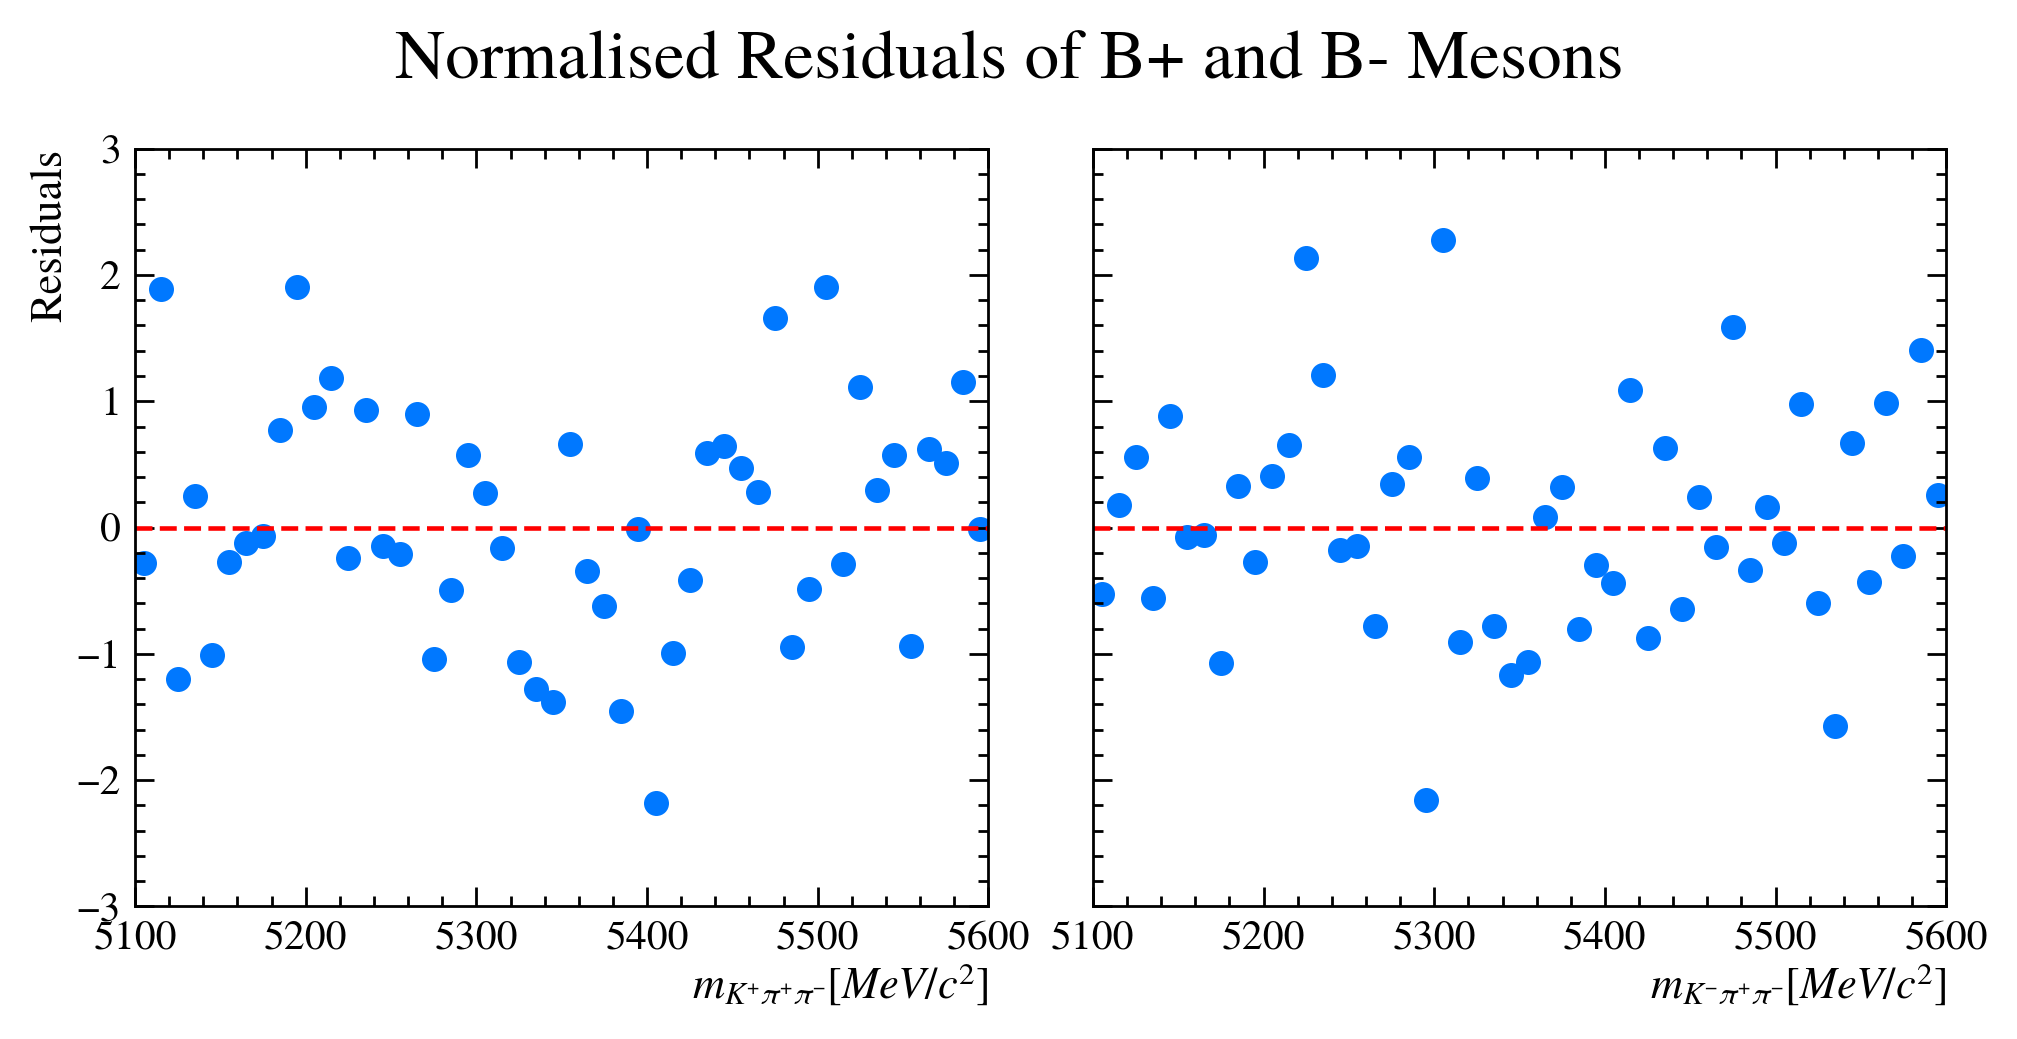

In [44]:
#obtain the residuals
positive_residuals = (positive_bin_heights - positive_model)/ np.sqrt(positive_bin_heights)
negative_residuals = (negative_bin_heights - negative_model) / np.sqrt(negative_bin_heights)

#plot the residuals in a new figure with them side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

#plot the residuals in ax1
ax1.scatter(positive_bin_centers, positive_residuals, 
                ls="None")
ax1.set_ylim(bottom=-20, top=20)
ax1.set_xlim(5100, 5600)
ax1.set_xlabel(r"$m_{K^{+}\pi^{+}\pi^{-}} [MeV/c^2]$")
ax1.set_ylabel("Residuals")
ax1.axhline(0, color="red", ls="dashed")

#plot the residuals in ax2
ax2.scatter(negative_bin_centers, negative_residuals, 
                ls="None")
ax2.set_ylim(bottom=-3, top=3)
ax2.set_xlim(5100, 5600)
ax2.set_xlabel(r"$m_{K^{-}\pi^{+}\pi^{-}} [MeV/c^2]$")
ax2.axhline(0, color="red", ls="dashed")

#set a title of residuals of B+ and B- and put in the middle
fig.suptitle("Normalised Residuals of B+ and B- Mesons", fontsize=50, y=1)


Text(0.5, 1, 'Normalised Residuals of B+ and B- Mesons')

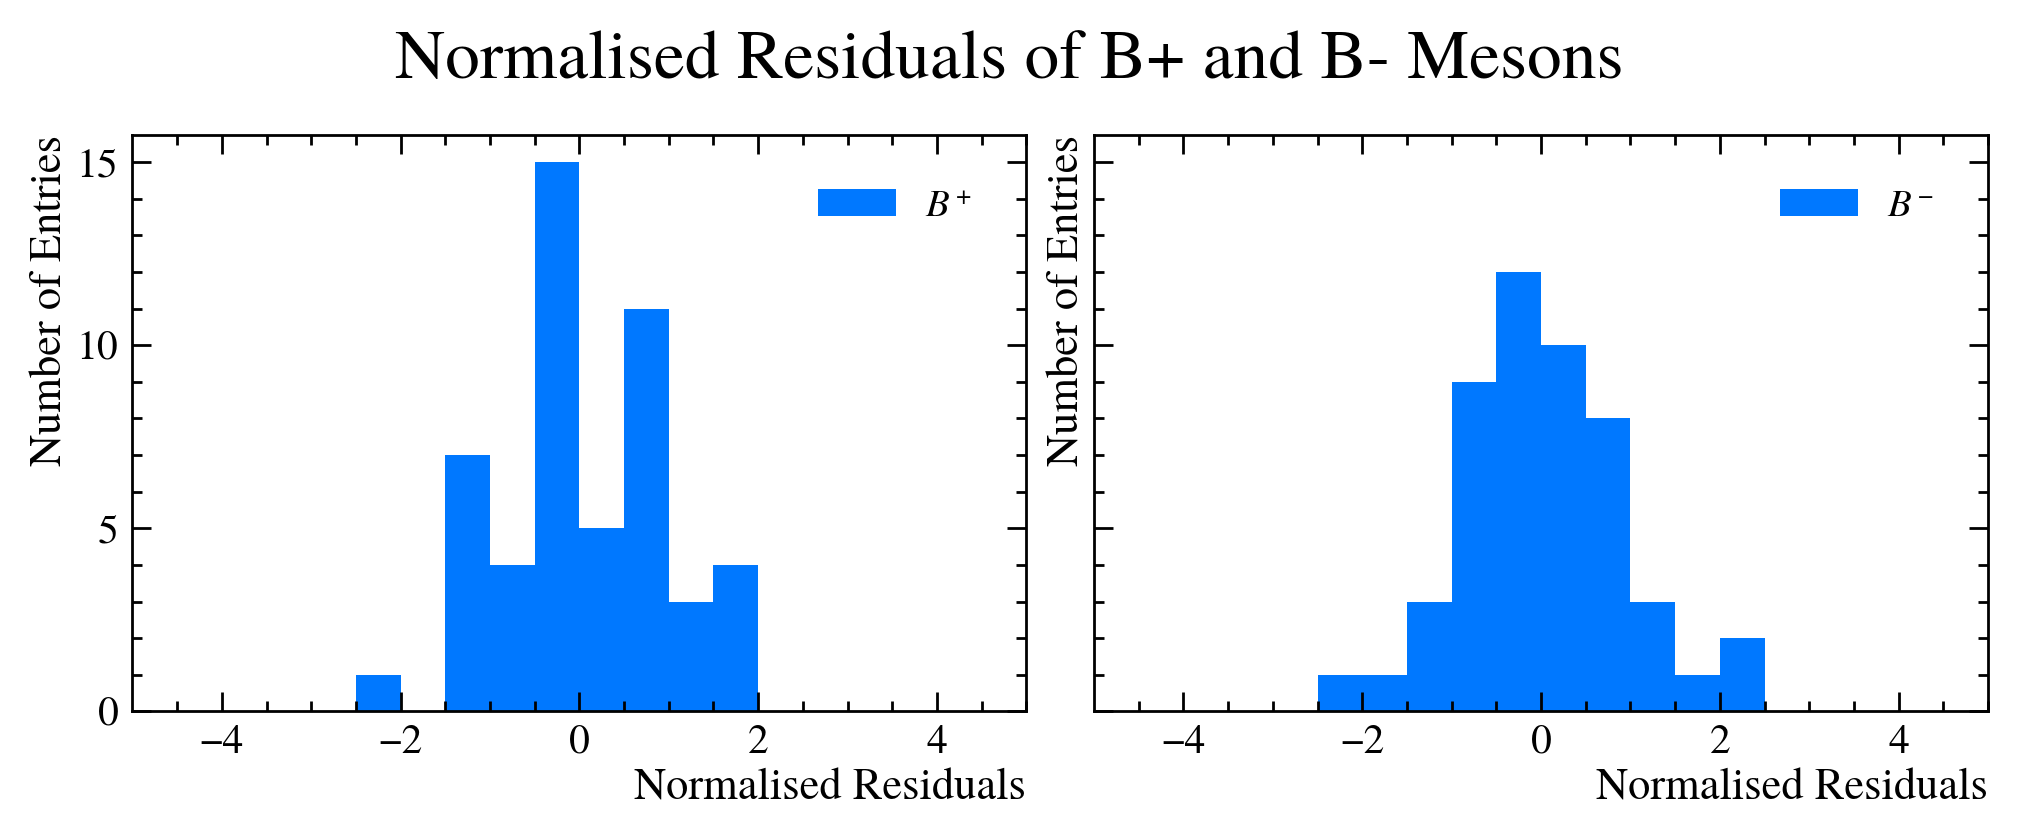

In [51]:
#plot the normalised residuals side by side as a histogram in a new figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

#plot the normalised residuals in ax1
ax1.hist(positive_residuals, bins=20, range=(-5, 5), label="$B^+$")
ax1.set_xlabel("Normalised Residuals")
ax1.set_ylabel("Number of Entries")
ax1.set_xlim(-5, 5)
ax1.legend(loc="upper right")
#plot the normalised residuals in ax2
ax2.hist(negative_residuals, bins=20, range=(-5, 5), label="$B^-$")
ax2.set_xlabel("Normalised Residuals")
ax2.set_ylabel("Number of Entries")
ax2.set_xlim(-5, 5)
ax2.legend(loc="upper right")

#set a title of normalised residuals of B+ and B- and put in the middle
fig.suptitle("Normalised Residuals of B+ and B- Mesons", fontsize=50, y=1)
#set the super y label
